# Black Implied Volatility & LIBOR Market Models

## Setup

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Problem 1

- Todays date is Jauary 1. 2017 and the 3M LIBOR fixing has just been announced.
- A client who needs to pay 3M LIBOR on a loan of 1 British pound on April 1. 2017, July 1. 2017, October 1. 2017, January 1. 2018, April 1. 2018 July 1. 2018, October 1. 2018 and finally on January 1. 2019. Each of these payments equal the fixing announced exactly 3 months prior. 
- The client wishes to protect himself from 3M LIBOR exceeding 0.045 and your job will be to quote a risk-neutral price on an interest rate cap with a strike of $R=0.045$. 
- Assume that the year has 360 days, that each month has 30 days and that there is no credit risk. 

The ZCB prices are 
$$
\begin{array}{lcccccccc}
T_i & 0.25 & 0.50 & 0.75 & 1.00 & 1.25 & 1.50 & 1.75 & 2.00 \\
\hline p\left(0, T_i\right) & 0.99228605 & 0.98417493 & 0.97571048 & 0.96693366 & 0.95788267 & 0.94859299 & 0.93909755 & 0.92942683 \\
\hline
\end{array}
$$

Also, you can see from market data that Black Implied Volatilities, $\sigma_i$, for caplets on $3 \mathrm{M}$ with maturities $T_i$ and resettlement date one quarter earlier with a strike of 0.045 are
$$
\begin{array}{cccccccc}
T_i & 0.50 & 0.75 & 1.00 & 1.25 & 1.50 & 1.75 & 2.00 \\
\hline \sigma_i & 0.15 & 0.19 & 0.23 & 0.27 & 0.3 & 0.33 & 0.36 \\
\hline
\end{array}
$$

### Find Spot Rates, 3M Forward Rates, 3M Forward Libor Rates and Plot Term Structures

We set up the information we know:

In [2]:
# compute array of time to maturities for T={0.0,0.5,...,10}
T_max = 2
alpha = 0.25
M = int(T_max/alpha)+1
T = np.array([i*alpha for i in range(M)])

p = np.array([1.0,0.99228605,0.98417493,0.97571048,0.96693366,0.95788267,0.94859299,0.93909755,0.92942683]) 

strike = 0.045 # R
sigma_market = np.array([np.nan,np.nan,0.15,0.19,0.23,0.27,0.3,0.33,0.36])

We compute rates:

In [3]:
R = fid.zcb_to_spot_rates(T,p)
f_3M = fid.zcb_to_forward_rates(T,p,horizon=1)
f_libor_rates = fid.zcb_to_forward_LIBOR_rates(T,p,horizon=1)

In [4]:
f_libor_rates

array([0.        , 0.03109567, 0.03296617, 0.03470066, 0.03630785,
       0.03779582, 0.03917246, 0.04044496, 0.04162015])

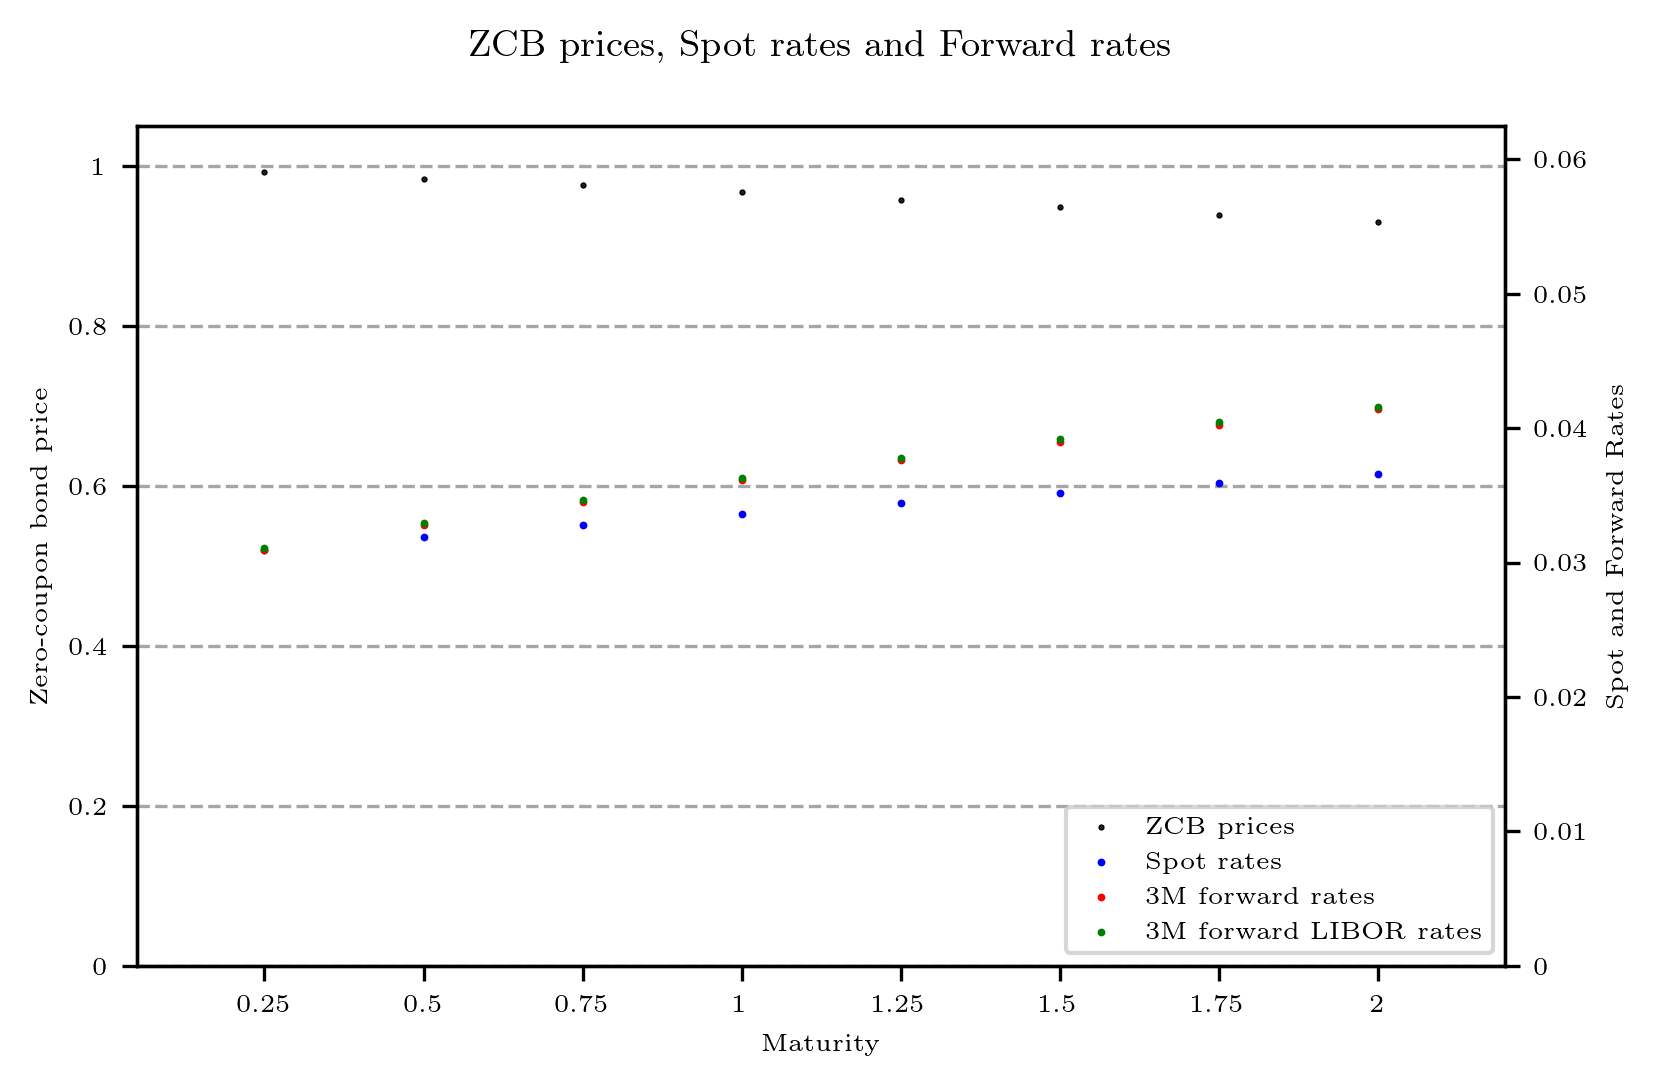

In [105]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"ZCB prices, Spot rates and Forward rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0.25,0.5,0.75,1,1.25,1.5,1.75,2]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0625])
p2 = ax1.scatter(T, R, s = 3, color = 'blue', marker = ".",label="Spot rates")
p3 = ax1.scatter(T[1:], f_3M[1:], s = 3, color = 'red', marker = ".",label="3M forward rates")
p4 = ax1.scatter(T[1:], f_libor_rates[1:], s = 3, color = 'green', marker = ".",label="3M forward LIBOR rates")

plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

The Libor rate is computed as simpe rates, whereas regular spot and forward rates are continuously compounded. They are close but not the same.

### B) Explain why there is no caplet available for a maturity of $T=0.25$ and resettlement at $T=0$, and compute the caplet prices corresponding to the remaining maturities.

In principle there could be, presetn time is zero and there is no reason to suspect there not to be a caplet. But the Libor has been announced cf. Text, then there is no risk to hedge or a pricing problem (since if we know libor then [libor - strike K] is known).

### C) Compute the price of the cap that would prevent the client from ever paying more than 0.045 on his floating rate obligation.

We sum from index 2 and beyond due to (usually Jacob includes time zero). Price of fixed swap leg (coupon rate R) $N P V=: \sum_{i=1}^N \alpha_i p\left(t, T_i\right) R=$ price of cap, where $\sum_i^N \alpha p\left(t, T_i\right)$ is the accrual factor. Payer swap increases by amount proportional to accrual factor. The premium is 20 basis points, so rather than paying usual floating rate, the client pays floating leg +20 basis points. However, now the client knows that he will not pay more than $4.5 \%$.

We can use the sigma (Black Implies Volatilites) to price the caplets. We use function from library “black_caplet_price”.

In [111]:
idx_n, idx_N = 2, 8 # no caplet for index 0,1 since we already know and thus no uncertainty

price_caplet = np.zeros([M])
alpha = np.zeros([M])
L = np.zeros([M])

for i in range(1,M):
    alpha[i] = T[i]-T[i-1] # will be quarterly
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]
    if i > 1:
        price_caplet[i] = fid.black_caplet_price(sigma_market[i],T[i],strike,alpha[i],p[i],L[i],type='call') 
    
price_cap = np.sum(price_caplet)
print(f"cap price: {price_cap} which is paid upfront.")

cap price: 0.003968849870742472 which is paid upfront.


### D) The client would like to not pay for this cap upfront but rather pay a fixed premium at the dates where he pays regular interest on his floating rate obligation. Find the premium that the client would have to pay to your bank quarterly starting at April 1. 2017 and ending January 1. 2019 should he enter into the interest rate cap.

In [112]:
S_swap = fid.zcb_to_accrual_factor(T[0],T[idx_N],'quarterly',T,p)
#distributed price of caps into payments as a spread on top of floating rate in order to be insured against floating rate of >4.5 % (strike)
premium = (price_cap/S_swap) 
print(f"premium: {premium} GBP, premium: {int(premium*10_000)} bps.")

premium: 0.0020633197951988856 GBP, premium: 20 bps.


### E) Alternatively, you can offer the client to pay a fixed rate by offering him an interest rate swap. What would be the fixed rate that the client would need to pay instead of $3 \mathrm{M}$ LIBOR?

In [116]:
R_swap = fid.zcb_to_par_swap_rate(T[0],T[idx_N],'quarterly',T,p)
print(f"Par swap rate: {R_swap}.")

Par swap rate: 0.03668947514099221.


If enters payer swap he recieves floats and fix today his future obligations at some rate. Remember par swap is averagee of forward rates. 

### F) From the viewpoint of the client, discuss the pros and cons of these different two methods of eliminating interest rate risk.

### G) Also discuss the pros and cons, if any, seen from the viewpoint of your financial institution. Do any these trades involve risk for the bank? How can the bank minimize/eliminate the risk from offering the client any of the two different solutions.

## Problem 2

Computes the Black implied volatility for a caplet. 
- compute caplet price $C$, time to maturity $T_i$, strike $R$, tenor $\alpha$, ZCB price $p\left(0, T_i\right)$ and LIBOR rate $L_i(0)$ 
- compute the  Black implied volatility of the caplet.

Essentially, this is a root finding problem.

In Black-76, we usually have the sigma ( $1^{\text {st }}$ axis), to find the price ( $2^{\text {nd }}$ axis), where the price is an increasing function in sigma.

But we have to revert it, let's say we know the price is $\bar{c}$, then we have to finde what is the $\bar{\sigma}$.
One way to do thus, is trial and error: We first try $\sigma_0$, then look what price this gives, if it is below $\bar{c}$, we know we need a higher one, etc. etc.

But we can do the following: if we have the formula for a caplet, in Black's model,
$$
\operatorname{capl}^B(T, \sigma) \approx \operatorname{capl}^B\left(t, \sigma_d\right)+\frac{\partial}{\partial \sigma} \operatorname{Capl}^B\left(t, \sigma_0\right) \epsilon+\frac{1}{2} \ldots
$$

But to do this approximation, we need to know the derivative of the caplet price w.r.t. $\sigma$, which is commonly referred to vega (one of the greeks).

$$
\begin{aligned}
& a_i p_i(t)\left[L_i(t) \Phi\left(d_1\right)-R \Phi\left(-d_2\right)\right] \\
& d_1=\frac{1}{\sigma_i \sqrt{T_i-t}}\left[\ln \left(\frac{L_i(t)}{R}\right)+\frac{1}{\phi} \sigma_i^2\left(T_i-t\right)\right), \quad d_2=d_1-\sigma \sqrt{T-t}
\end{aligned}
$$
(the i's are not really needed important here). So we need that $d_1$ and $d_2$ are inside $\Phi$, and what is this?
$$
\begin{gathered}
\Phi\left(d_1\right)=\int_{-\infty}^{d_1} \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} z^2} d z \quad \frac{\partial}{\partial d_1} \Phi\left(d_1\right)=\Phi\left(d_1\right)=\frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} d_1^2} \\
\frac{\left.\partial C a p\right|^B}{\partial \sigma}=\alpha p\left[L \Phi\left(d_1\right) \frac{\partial d_1}{\partial \sigma}-R \phi\left(d_1-\sigma \sqrt{T-t}\right) \frac{\partial\left(d_1-\sigma \sqrt{T-t}\right)}{\partial \sigma}\right. \\
\phi\left(d_1-\sigma \sqrt{T-t}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left(d_1-\sigma \sqrt{T-t}\right)^2\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2} d_1^2+d_1 \sigma \sqrt{T-t}-\frac{\sigma^2}{2}(T-t)\right) \\
\phi\left(d_1\right) \exp \left(\ln \left(\frac{L(t)}{R}\right)+\frac{1}{2} \sigma^2(T-t)-\frac{\sigma^2}{2}(T-t)\right)
\end{gathered}
$$
Then, exponential and log cancel
$$
=\phi\left(d_1\right) \frac{L(t)}{R}
$$

So, that was the expression $\phi\left(d_1-\sigma \sqrt{T-t}\right)$
Let's proceed:
$$
\frac{\partial \operatorname{Capl}^B}{\partial \sigma}=\alpha p\left[L \phi\left(d_1\right) \frac{\partial d_1}{\partial \sigma}-R \phi\left(d_1-\sigma \sqrt{T-t}\right) \frac{\partial\left(d_1-\sigma \sqrt{T-t}\right)}{\partial \sigma}\right.
$$

Now setting in the part we just derived:
$$
\begin{aligned}
& \frac{\partial \operatorname{Capl}^B}{\partial \sigma}=\alpha p\left[L \phi\left(d_1\right) \frac{\partial d_1}{\partial \sigma}-R \phi\left(d_1\right) \frac{L(t)}{R}\left(\frac{\partial d_1}{\partial \sigma}-\sqrt{T-t}\right)\right. \\
& =\alpha p L(t) \phi\left(d_1\right) \sqrt{T-t}
\end{aligned}
$$
Computing vega using:
$$
\text { vega }=\alpha p L(t) \phi\left(d_1\right) \sqrt{T-t}
$$

In [117]:
sigma = 0.25
precision = 1e-10
T, R, alpha, p, L = 2, 0.04, 0.25, 0.92, 0.04
price_caplet = fid.black_caplet_price(sigma,T,R,alpha,p,L,type = 'call')
iv_caplet = fid.black_caplet_iv(price_caplet,T,R,alpha,p,L, iv0 = 0.2, max_iter = 200, prec = precision)

In [118]:
iv_caplet

0.24999999679393847

So the formular returns 0.2499999999, which is very close to 0.25 which we initially stated.

## Problem 3

Suppose present time is set to $t=0$ and you have market data for zero coupon bond prices and 6M LIBOR caplet prices $C_i$ corresponding to the maturity dates $T_i$, a strike of $R=0.035$ and a principal of one EUR seen in the table below. Also note that the resettlement (LIBOR fixing announcement) dates are all one period prior. That, is the LIBOR rate serving as the underlying for the $T_i=1$ caplet is announced at time $T_{i-1}=0.5$.

$$
\begin{array}{lcccccccc}
T_i & 0.50 & 1.0 & 1.5 & 2.0 & 2.50 & 3.9 & 3.5 & 4.0 \\
\hline C_i(0) & - & 0.00066856 & 0.00190329 & 0.00323934 & 0.00455614 & 0.00582274 & 0.00702734 & 0.0081621 \\
p_i(0) & 0.98530023 & 0.96939649 & 0.95255338 & 0.93499966 & 0.91693156 & 0.89851614 & 0.87989458 & 0.86118526 \\
\hline
\end{array}
$$

In [132]:
# setup
M, delta = 9, 1/2
T = np.array([i*delta for i in range(0,M)])
C = np.array([0,0,0.00062138,0.00193406,0.00329997,0.00462232,0.00588119,0.00707032,0.00818548])
p = np.array([1,0.98530023,0.96939649,0.95255338,0.93499966,0.91693156,0.89851614,0.87989458,0.86118526])
R = 0.035

If the Libor rate exceeds $3.5 \%$ then owner receives difference between realized libor and 3.5\% \times Notianoal (or how many caplets the investor owns).
# A) Find spotrates, $6 \mathrm{M}$ forward rates and $6 \mathrm{M}$ forward LIBOR rates. Plot.

In [133]:
R_spot = fid.zcb_to_spot_rates(T,p)
f = fid.zcb_to_forward_rates(T,p,horizon = 1)
L = fid.zcb_to_forward_LIBOR_rates(T,p,horizon = 1)

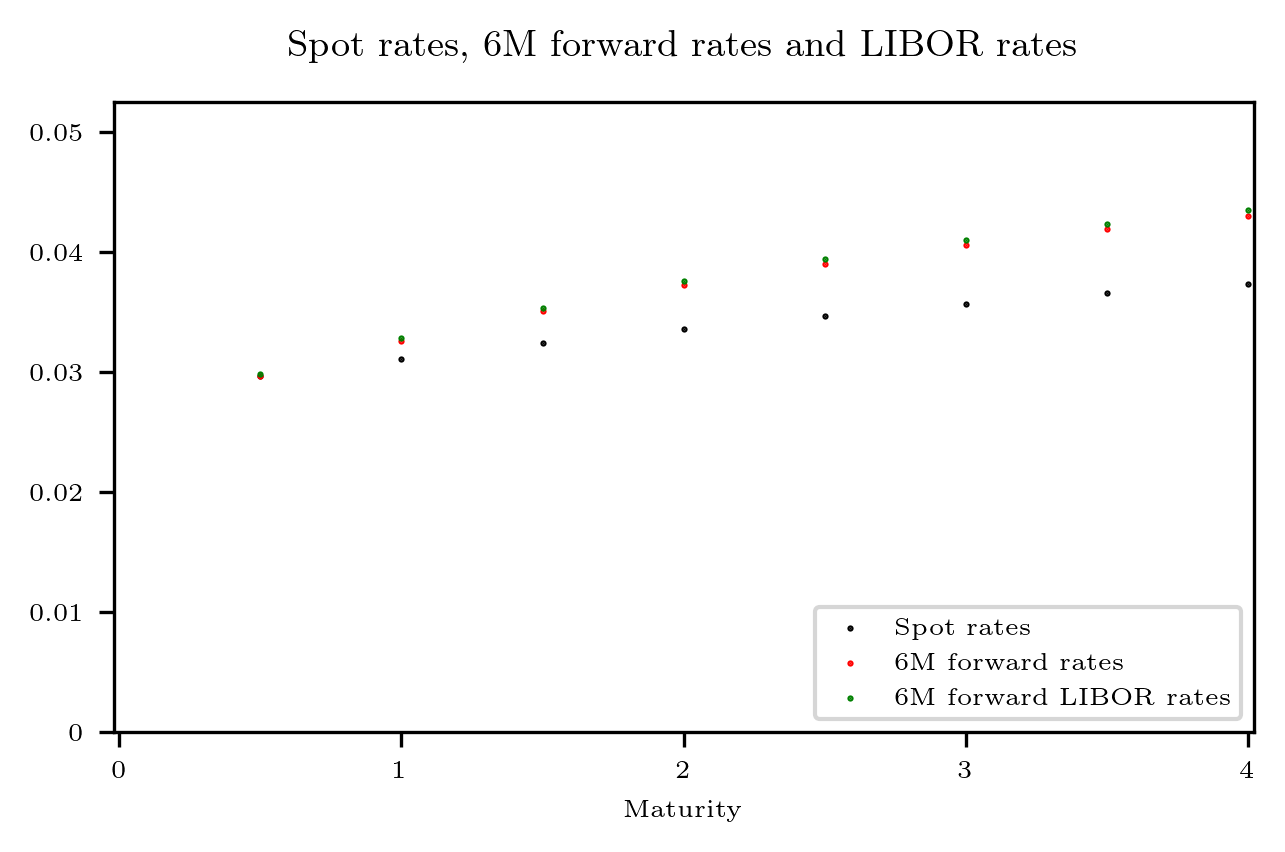

In [134]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Spot rates, 6M forward rates and LIBOR rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax.set_ylim([0,0.0525])
# ax.set_ylabel(f"",fontsize = 6)
p1 = ax.scatter(T[1:], R_spot[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], f[1:], s = 1, color = 'red', marker = ".",label="6M forward rates")
p3 = ax.scatter(T[1:], L[1:], s = 1, color = 'green', marker = ".",label="6M forward LIBOR rates")

plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)

plt.show()

In plot: we see $6 \mathrm{M}$ forward rates \& LiBor forward are very close, but differ due to compounding. The relation would be something like: $R(t, T)(T-$ $T) \approx \exp (R(t, T)(T-T))=\frac{1}{p(t, T)}=1+L(t, T)(T-t)$

### B) Find the Black implied volatilities $\bar{\sigma}_i$ corresponding to these caplet prices and plot the term structure of Black implied volatilities. (You should get numbers ranging between 0.23 for $T=1$ and 0.51 for $T=4$.)

In [135]:
iv = np.zeros([M])
for i in range(2,M):                        
    iv[i] = fid.black_caplet_iv(C[i],T[i],R,T[i]-T[i-1],p[i],L[i], iv0 = 0.2, max_iter = 400, prec = 1.0e-15)
print(f"Term Structure of Implied Volatility: {iv}")

Term Structure of Implied Volatility: [0.         0.         0.23093713 0.2770409  0.32351558 0.37032648
 0.41744067 0.46482954 0.51246676]


### C) Libor Market Model

In the following you are to construct a LIBOR market model based on the Black implied volatilities you have just computed. That is, you will assume a model where LIBOR rates have dynamics of the form
$$
d L_i(t)=L_i(t) \sigma_i(t) d W_i(t), \quad 0 \leq t<T_{i-1}
$$
and your job will be to determine the coefficients $\sigma_i$ that are consistent with the term structure of Black implied volatilities you have just found. To do this, assume that for the caplet with maturity $T_i$ and resettlement date $T_{i-1}, \sigma_i(t)$ is piecewise constant and of the following form
$$
\sigma_i(t)=\sigma_{i j}=\beta_{i-j}, \quad \text { for } T_{j-1}<t<T_j, j=0, \ldots, i-1
$$
### C) For $i=2, \ldots 8$ denote $T_2=1, \ldots, T_8=4$ and note that there is the following relationship between the Black implied volatilities $\bar{\sigma}_i$ and the diffusion coefficients in the dynamics of LIBOR rates $\sigma_i(t)$
$$
\bar{\sigma}_i^2=\frac{1}{T_{i-1}} \int_{t=0}^{T_{i-1}} \sigma_i^2(s) d s
$$

Use this relation to find a linear system of equations relating the $\bar{\sigma}_i$ and the $\beta_{i-j}$ for $i=2, \ldots, 8$

simply: We are working with Libor Market model. We need a model consistent with prices of caplets. Caplets are trading in the market, and the maturity. Remember, equivalent between implied volality and price.

So we are looking for the choice of sigma that implies sigma gives us Black IV 0.37 for caplet at maturity 2 . The condition that has to hold is that the diffusion coefficeint and the sigma is that
$$
\bar{\sigma}_i^2=\frac{1}{T_{i-1}} \int_0^{T_{i-1}} \sigma_i^2(t) d t
$$
I.e., the average of the diffusion coefficient has to be equal to black implied volaitlity deduced from market caps. This is done for all maturities (all i's).
- We exclude periods after due to libor rate for T i being announce at $\mathrm{t}_{i-1}$ it stops wiggling around and is announced (settlement/fixing date).

However, we can come up with a lot of functional forms for sigma(t).

So the exercise is about what conditions must sigma meet such that we can price caplets.

### D) Solve your linear system of equations to find the coefficients $\beta_1, \ldots, \beta_7$.

In [136]:
# c) and d)
N = M - 2
y = iv[2:]**2
A = 0.5*np.tri(N)
for i in range(2,M):
    A[i-2,:] = A[i-2,:]/T[i-1]
beta = (np.linalg.solve(A,y))**0.5
print(f"beta vector: {beta}")

beta vector: [0.23093713 0.3164986  0.40060412 0.48433441 0.56808164 0.6520088
 0.73617678]
